In [1]:
import os
import kagglehub

path = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")

print("Path to dataset files:", path)

# List the contents of the downloaded directory
print("Contents of the directory:", os.listdir(path))

100%|██████████| 199M/199M [00:04<00:00, 45.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2
Contents of the directory: ['The IQ-OTHNCCD lung cancer dataset', 'Test cases']


In [ ]:
import os

DATASET_PATH = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2"
subfolders = os.listdir(os.path.join(DATASET_PATH, "The IQ-OTHNCCD lung cancer dataset"))

print("Contents of 'The IQ-OTHNCCD lung cancer dataset':", subfolders)


Contents of 'The IQ-OTHNCCD lung cancer dataset': ['The IQ-OTHNCCD lung cancer dataset']


In [ ]:
import os

# Define base dataset path
BASE_PATH = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2"
NESTED_PATH = os.path.join(BASE_PATH, "The IQ-OTHNCCD lung cancer dataset", "The IQ-OTHNCCD lung cancer dataset")

# List contents of the nested folder
print("Final dataset folder contents:", os.listdir(NESTED_PATH))

Final dataset folder contents: ['IQ-OTH_NCCD lung cancer dataset.txt', 'Malignant cases', 'Bengin cases', 'Normal cases']


In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical

# Dataset Paths
RAW_DATASET_PATH = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset"
OUTPUT_PATH = "cleaned_dataset"
IMG_SIZE = 224  # Image resize size

# Class categories
CATEGORIES = ["Bengin cases", "Malignant cases", "Normal cases"]

# Ensure output directory exists
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Function to process images and save them
def process_and_save_images():
    data, labels = [], []

    for label, category in enumerate(CATEGORIES):
        input_folder = os.path.join(RAW_DATASET_PATH, category)
        output_folder = os.path.join(OUTPUT_PATH, category)
        os.makedirs(output_folder, exist_ok=True)  # Ensure subfolders exist

        print(f"Processing {category}...")

        for img_name in tqdm(os.listdir(input_folder)):
            img_path = os.path.join(input_folder, img_name)

            try:
                # Read image in RGB
                img = cv2.imread(img_path)
                if img is None:
                    continue

                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # Ensure RGB format

                # Save processed image
                output_img_path = os.path.join(output_folder, os.path.splitext(img_name)[0] + ".jpg")
                cv2.imwrite(output_img_path, img)

                # Normalize and store in dataset arrays
                img = img.astype("float32") / 255.0
                data.append(img)
                labels.append(label)

            except Exception as e:
                print(f"❌ Error processing {img_name}: {e}")

    return np.array(data), np.array(labels)

# Process images
data, labels = process_and_save_images()

# Ensure images were processed before splitting
if len(data) == 0:
    raise RuntimeError("No images processed! Check dataset path.")

# Train-validation-test split (80-10-10)
x_temp, x_test, y_temp, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train.reshape(-1, IMG_SIZE * IMG_SIZE * 3), y_train)
x_train_resampled = x_train_resampled.reshape(-1, IMG_SIZE, IMG_SIZE, 3)  # Reshape back

# Convert labels to categorical
y_train_resampled = to_categorical(y_train_resampled, num_classes=3)
y_valid = to_categorical(y_valid, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Save preprocessed data
np.save("x_train.npy", x_train_resampled)
np.save("y_train.npy", y_train_resampled)
np.save("x_valid.npy", x_valid)
np.save("y_valid.npy", y_valid)
np.save("x_test.npy", x_test)
np.save("y_test.npy", y_test)

print("✅ Preprocessing complete! Images saved in 'cleaned_dataset/' and arrays saved as .npy files.")


Processing Bengin cases...


100%|██████████| 120/120 [00:00<00:00, 197.23it/s]


Processing Malignant cases...


100%|██████████| 561/561 [00:02<00:00, 242.89it/s]


Processing Normal cases...


100%|██████████| 416/416 [00:02<00:00, 159.16it/s]


✅ Preprocessing complete! Images saved in 'cleaned_dataset/' and arrays saved as .npy files.


In [ ]:



import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load preprocessed data
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_valid = np.load("x_valid.npy")
y_valid = np.load("y_valid.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

# Define DenseNet169 model
base_model = DenseNet169(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(3, activation="softmax")(x)  # 3 classes: Benign, Malignant, Normal

# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train model with early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=28,
    batch_size=32,
    callbacks=callbacks
)

# Save trained model
model.save("lung_cancer_densenet169.h5")

print("✅ Model training complete and saved as 'lung_cancer_densenet169.h5'.")

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

Epoch 1/28
37/37 ━━━━━━━━━━━━━━━━━━━━ 307s 8s/step - accuracy: 0.4717 - loss: 1.0771 - val_accuracy: 0.8364 - val_loss: 0.5021
Epoch 2/28
37/37 ━━━━━━━━━━━━━━━━━━━━ 296s 7s/step - accuracy: 0.7360 - loss: 0.6134 - val_accuracy: 0.8818 - val_loss: 0.4090
Epoch 3/28
37/37 ━━━━━━━━━━━━━━━━━━━━ 271s 7s/step - accuracy: 0.8414 - loss: 0.4502 - val_accuracy: 0.9000 - val_loss: 0.3186
Epoch 4/28
37/37 ━━━━━━━━━━━━━━━━━━━━ 302s 7s/step - accuracy: 0.8790 - loss: 0.3690 - val_accuracy: 0.9091 - val_loss: 0.3009
Epoch 5/28
37/37 ━━━━━━━━━━━━━━━━━━━━ 282s 7s/step - accuracy: 0.8946 - loss: 0.3300 - val_accuracy: 0.9182 - val_loss: 0.2778
Epoch 6/28
37/37 ━━━━━━━━━━━━━━━━━━━━ 302s 7s/step - accuracy: 0.9048 - loss: 0.2759 - val_accuracy: 0.9364 - val_loss: 0.2458
Epoch 7/28
37/37 ━━━━━━━━━━━━━━━━━━━━ 276s 7s/step - accuracy: 0.9256 - loss: 0.2434 - val_accuracy: 0.9273 - val_loss: 0.2328
Epoch 8/28
37/37 ━━━━━━━━━━━━━━━━━━━━ 310s 7s/step - accuracy: 0.9495 - loss: 0.1972 - val_accuracy: 0.9364 - v

In [ ]:

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - accuracy: 0.9373 - loss: 0.1771
Test Accuracy: 0.95


7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step


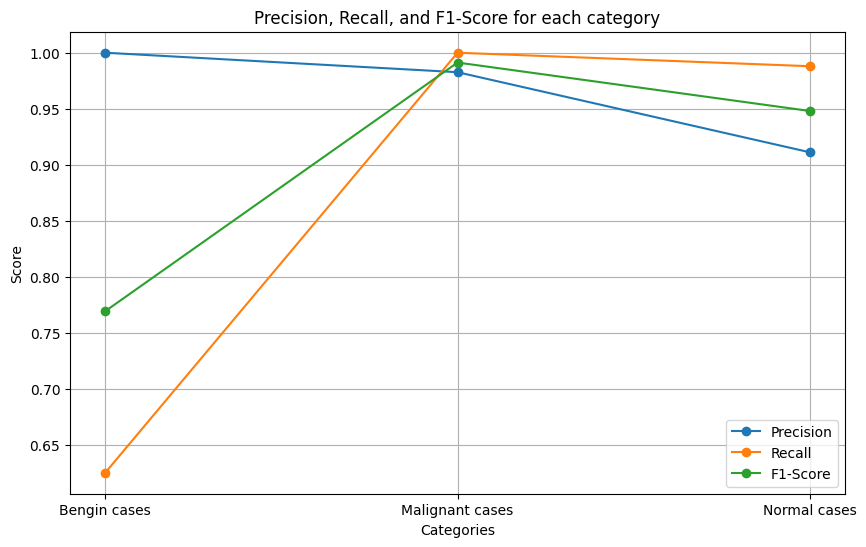

Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.62      0.77        24
Malignant cases       0.98      1.00      0.99       113
   Normal cases       0.91      0.99      0.95        83

       accuracy                           0.95       220
      macro avg       0.96      0.87      0.90       220
   weighted avg       0.96      0.95      0.95       220



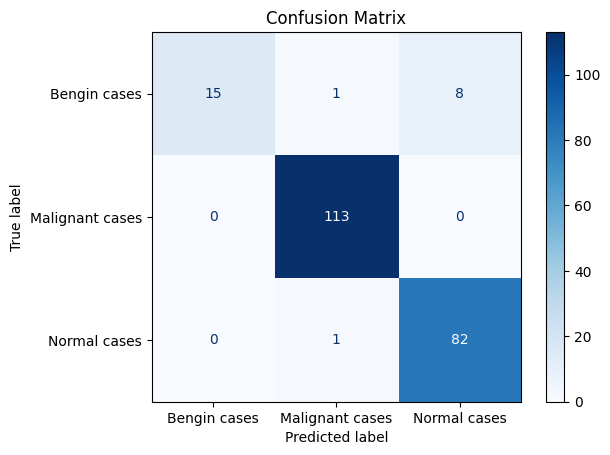

In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(x_test)
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

#  precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test_classes, y_pred_classes, average=None)


categories = ["Bengin cases", "Malignant cases", "Normal cases"]
plt.figure(figsize=(10, 6))

plt.plot(categories, precision, label="Precision", marker='o')
plt.plot(categories, recall, label="Recall", marker='o')
plt.plot(categories, f1, label="F1-Score", marker='o')

plt.title("Precision, Recall, and F1-Score for each category")
plt.xlabel("Categories")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=categories))


cm = confusion_matrix(y_test_classes, y_pred_classes)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
for image_path in sample_images:
    print(image_path)


/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (1).jpg
/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (106).jpg
/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (101).jpg


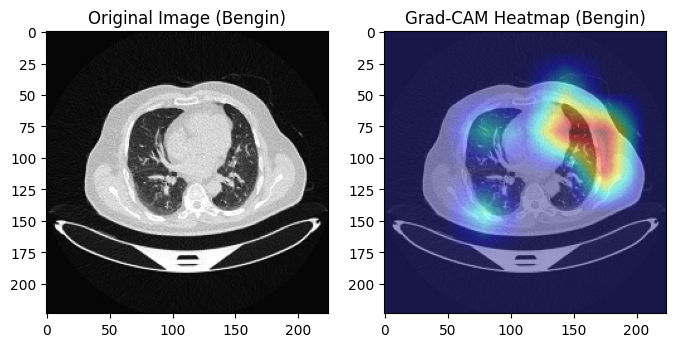

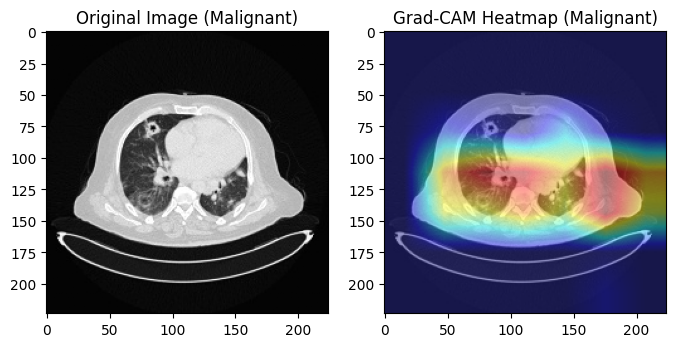

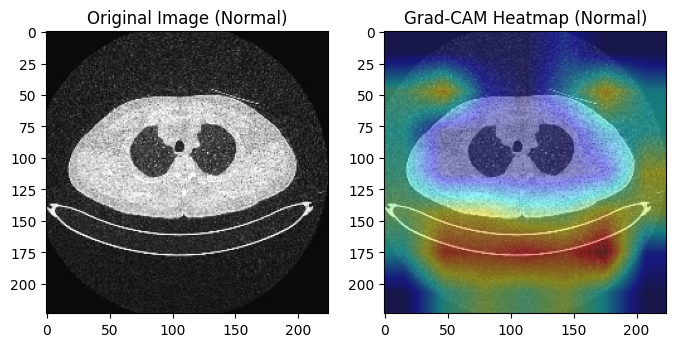

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model

# Load DenseNet169 model
model = tf.keras.applications.DenseNet169(weights="imagenet", include_top=True)
last_conv_layer_name = "conv5_block16_concat"  # Last convolutional layer in DenseNet169

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Apply gradients to feature maps
    conv_output = conv_output[0]
    heatmap = np.dot(conv_output, pooled_grads.numpy())

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap) if np.max(heatmap) != 0 else heatmap
    heatmap = np.power(heatmap, 0.8)  # Enhancing contrast

    return heatmap

# Function to apply Grad-CAM on an image
def apply_gradcam(image_path, label, model, last_conv_layer_name, input_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, input_size) / 255.0
    img_array = np.expand_dims(np.repeat(img_resized[..., np.newaxis], 3, axis=-1), axis=0)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmap_resized = cv2.resize(heatmap, input_size)
    heatmap_resized = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_resized = cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB)

    # Overlay heatmap on original image
    overlay = cv2.addWeighted(cv2.cvtColor((img_resized * 255).astype('uint8'), cv2.COLOR_GRAY2RGB), 0.6, heatmap_resized, 0.4, 0)

    # Display results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original Image ({label})")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM Heatmap ({label})")
    plt.show()


# Sample images for DenseNet169
sample_images = [
    '/content/cleaned_dataset/Bengin cases/Bengin case (1).jpg',
    '/content/cleaned_dataset/Malignant cases/Malignant case (106).jpg',
    '/content/cleaned_dataset/Normal cases/Normal case (101).jpg'
]


labels = ["Bengin", "Malignant", "Normal"]
input_size = (224, 224)  # Required input size for DenseNet169

# Apply Grad-CAM to images
for image_path, label in zip(sample_images, labels):
    apply_gradcam(image_path, label, model, last_conv_layer_name, input_size=input_size)


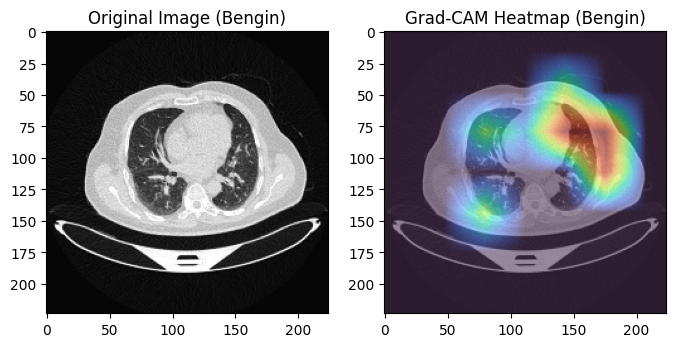

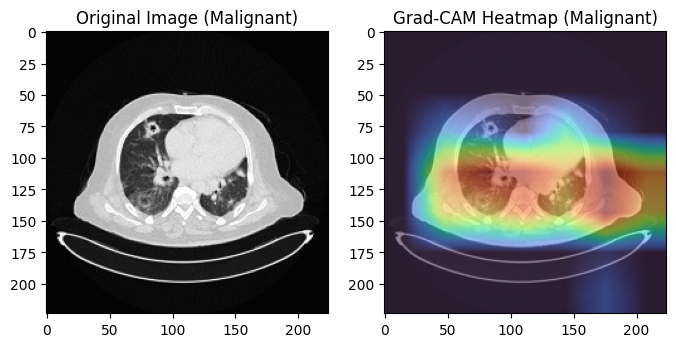

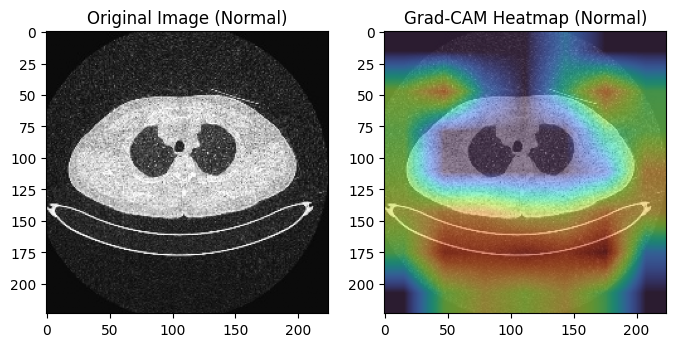

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model

# Load DenseNet169 model
model = tf.keras.applications.DenseNet169(weights="imagenet", include_top=True)
last_conv_layer_name = "conv5_block16_concat"  # Last convolutional layer in DenseNet169

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Apply gradients to feature maps
    conv_output = conv_output[0]
    heatmap = np.dot(conv_output, pooled_grads.numpy())

    # Normalize heatmap using percentile-based scaling
    heatmap = np.maximum(heatmap, 0)
    percentile_99 = np.percentile(heatmap, 99)  # Scale using 99th percentile
    heatmap = heatmap / percentile_99 if percentile_99 > 0 else heatmap
    heatmap = np.clip(heatmap, 0, 1)  # Keep values between 0 and 1
    heatmap = np.power(heatmap, 0.7)  # Further contrast enhancement

    return heatmap

# Function to apply Grad-CAM on an image
def apply_gradcam(image_path, label, model, last_conv_layer_name, input_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, input_size) / 255.0
    img_array = np.expand_dims(np.repeat(img_resized[..., np.newaxis], 3, axis=-1), axis=0)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmap_resized = cv2.resize(heatmap, input_size)

    # Use TURBO colormap for better heatmap visibility in medical images
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_TURBO)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Overlay heatmap on original image with dynamic contrast
    overlay = cv2.addWeighted(cv2.cvtColor((img_resized * 255).astype('uint8'), cv2.COLOR_GRAY2RGB), 0.5, heatmap_colored, 0.5, 0)

    # Display results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original Image ({label})")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM Heatmap ({label})")
    plt.show()

# Sample images for DenseNet169
sample_images = [
    '/content/cleaned_dataset/Bengin cases/Bengin case (1).jpg',
    '/content/cleaned_dataset/Malignant cases/Malignant case (106).jpg',
    '/content/cleaned_dataset/Normal cases/Normal case (101).jpg'
]

labels = ["Bengin", "Malignant", "Normal"]
input_size = (224, 224)  # Required input size for DenseNet169

# Apply Grad-CAM to images
for image_path, label in zip(sample_images, labels):
    apply_gradcam(image_path, label, model, last_conv_layer_name, input_size=input_size)


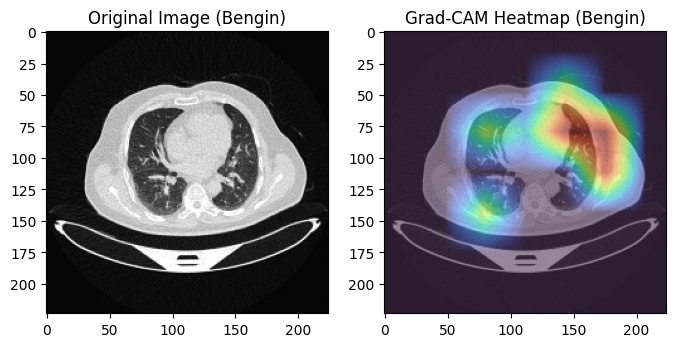

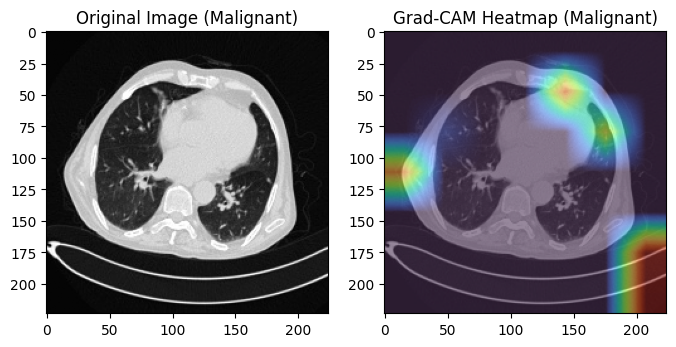

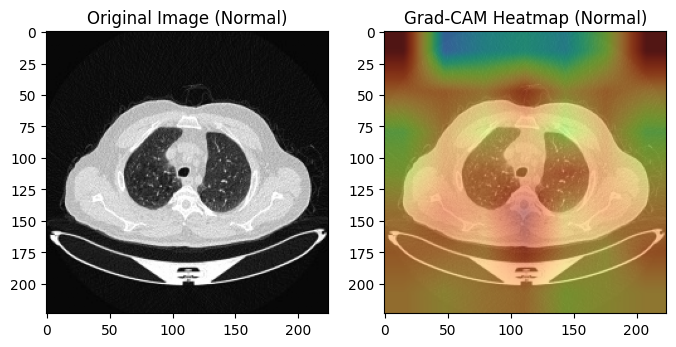

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model

# Load DenseNet169 model
model = tf.keras.applications.DenseNet169(weights="imagenet", include_top=True)
last_conv_layer_name = "conv5_block16_concat"  # Last convolutional layer

# Function to generate Grad-CAM heatmap with Guided Backpropagation
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(inputs=[model.input], outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Apply gradients to feature maps
    conv_output = conv_output[0]
    heatmap = np.dot(conv_output, pooled_grads.numpy())

    # Normalize heatmap using adaptive percentile scaling
    heatmap = np.maximum(heatmap, 0)
    percentile_98 = np.percentile(heatmap, 98)  # Scale using 98th percentile
    heatmap = heatmap / percentile_98 if percentile_98 > 0 else heatmap
    heatmap = np.clip(heatmap, 0, 1)  # Keep values between 0 and 1
    heatmap = np.power(heatmap, 0.6)  # Further contrast enhancement

    return heatmap

# Function to apply Guided Grad-CAM on an image
def apply_gradcam(image_path, label, model, last_conv_layer_name, input_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, input_size) / 255.0
    img_array = np.expand_dims(np.repeat(img_resized[..., np.newaxis], 3, axis=-1), axis=0)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmap_resized = cv2.resize(heatmap, input_size)

    # Apply Gaussian Smoothing for Normal Case (Reduce False Positives)
    if label == "Normal":
        heatmap_resized = cv2.GaussianBlur(heatmap_resized, (5, 5), 0)

    # Use TURBO colormap for better heatmap visibility
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_TURBO)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Overlay heatmap on original image with dynamic contrast
    overlay = cv2.addWeighted(cv2.cvtColor((img_resized * 255).astype('uint8'), cv2.COLOR_GRAY2RGB), 0.5, heatmap_colored, 0.5, 0)

    # Display results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original Image ({label})")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM Heatmap ({label})")
    plt.show()

# Sample images for DenseNet169
sample_images = [
    '/content/cleaned_dataset/Bengin cases/Bengin case (1).jpg',
    '/content/cleaned_dataset/Malignant cases/Malignant case (55).jpg',
    '/content/cleaned_dataset/Normal cases/Normal case (1).jpg'
]

labels = ["Bengin", "Malignant", "Normal"]
input_size = (224, 224)  # Required input size for DenseNet169

# Apply Grad-CAM to images
for image_path, label in zip(sample_images, labels):
    apply_gradcam(image_path, label, model, last_conv_layer_name, input_size=input_size)


In [ ]:
import tensorflow as tf

# Load DenseNet169 model
model = tf.keras.applications.DenseNet169(weights="imagenet", include_top=True)

# Print all layer names
for layer in model.layers[::-1]:  # Reverse search from the last layer
    if 'conv' in layer.name:
        print(layer.name)
        break  # Stop at the first convolutional layer found (last in the model)

conv5_block32_concat


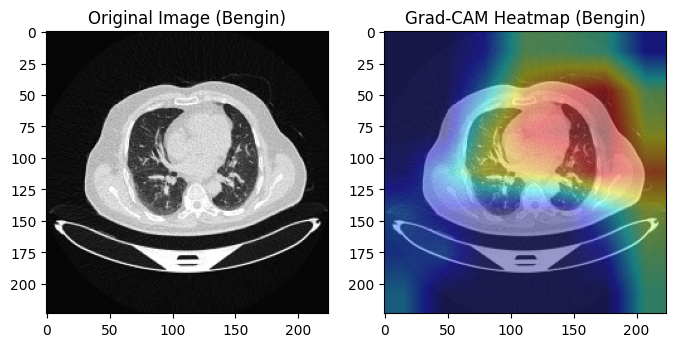

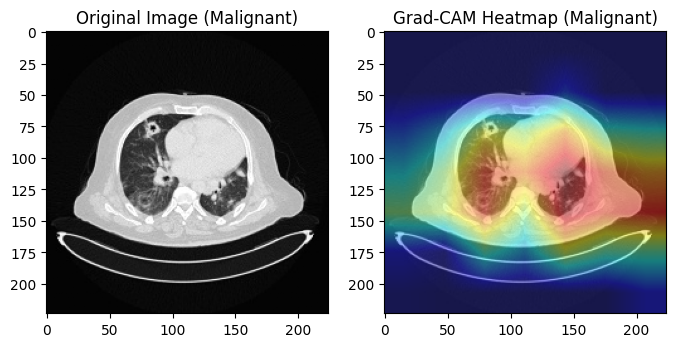

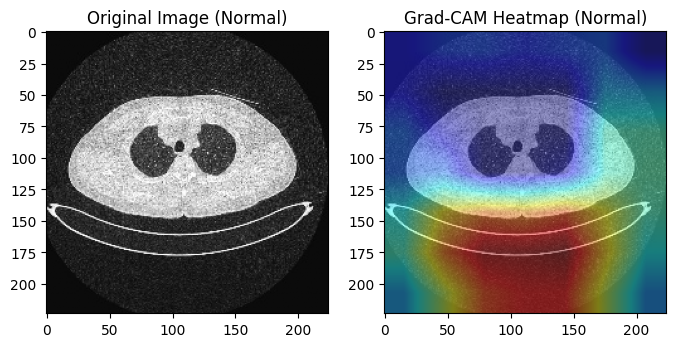

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model



def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)


    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)
    heatmap = np.power(heatmap, 0.8)
    return heatmap

def apply_gradcam(image_path, label, model, last_conv_layer_name, input_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, input_size) / 255.0
    img_array = np.expand_dims(np.repeat(img_resized[..., np.newaxis], 3, axis=-1), axis=0)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmap_resized = cv2.resize(heatmap, input_size)
    heatmap_resized = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_resized = cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(cv2.cvtColor((img_resized * 255).astype('uint8'), cv2.COLOR_GRAY2RGB), 0.6, heatmap_resized, 0.4, 0)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original Image ({label})")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM Heatmap ({label})")
    plt.show()



last_conv_layer_name = 'conv5_block32_concat'
# Sample images for DenseNet169
sample_images = [
    '/content/cleaned_dataset/Bengin cases/Bengin case (1).jpg',
    '/content/cleaned_dataset/Malignant cases/Malignant case (106).jpg',
    '/content/cleaned_dataset/Normal cases/Normal case (101).jpg'
]

labels = ["Bengin", "Malignant", "Normal"]
input_size = (224, 224)

for image_path, label in zip(sample_images, labels):
    apply_gradcam(image_path, label, model, last_conv_layer_name, input_size=input_size)


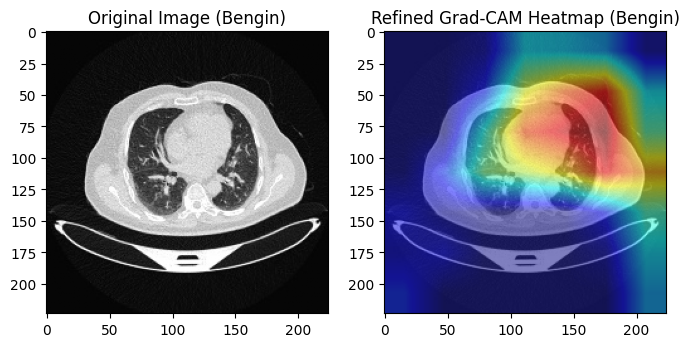

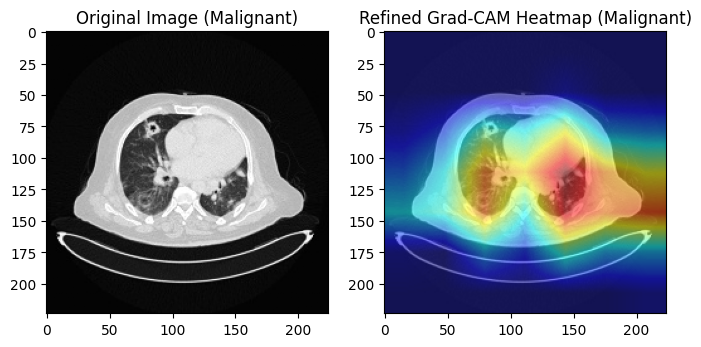

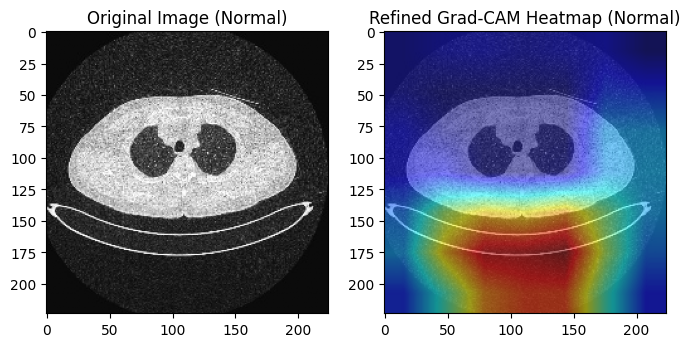

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model

# Function to create a refined Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, last_conv_output)

    # Normalize gradients
    grads = tf.divide(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)

    # Global Average Pooling (GAP)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply activation maps by the pooled gradients
    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1.0
    heatmap = np.power(heatmap, 1.2)  # Increase contrast dynamically

    return heatmap

# Function to apply Grad-CAM on a given image
def apply_gradcam(image_path, label, model, last_conv_layer_name, input_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, input_size) / 255.0
    img_array = np.expand_dims(np.repeat(img_resized[..., np.newaxis], 3, axis=-1), axis=0)

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Resize heatmap using bilinear interpolation for sharper details
    heatmap_resized = cv2.resize(heatmap, input_size, interpolation=cv2.INTER_LINEAR)

    # Convert to color map
    heatmap_resized = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_resized = cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB)

    # Adaptive thresholding to highlight key regions
    heatmap_resized = cv2.GaussianBlur(heatmap_resized, (5, 5), 0)

    # Sharpening filter to enhance details
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    heatmap_resized = cv2.filter2D(heatmap_resized, -1, kernel)

    # Overlay heatmap on grayscale image
    overlay = cv2.addWeighted(cv2.cvtColor((img_resized * 255).astype('uint8'), cv2.COLOR_GRAY2RGB), 0.5, heatmap_resized, 0.5, 0)

    # Display results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original Image ({label})")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Refined Grad-CAM Heatmap ({label})")
    plt.show()

# Applying Grad-CAM on sample images
last_conv_layer_name = 'conv5_block32_concat'  # Last convolutional layer
sample_images = [
    '/content/cleaned_dataset/Bengin cases/Bengin case (1).jpg',
    '/content/cleaned_dataset/Malignant cases/Malignant case (106).jpg',
    '/content/cleaned_dataset/Normal cases/Normal case (101).jpg'
]

labels = ["Bengin", "Malignant", "Normal"]
input_size = (224, 224)  # Input size required for DenseNet169

for image_path, label in zip(sample_images, labels):
    apply_gradcam(image_path, label, model, last_conv_layer_name, input_size=input_size)


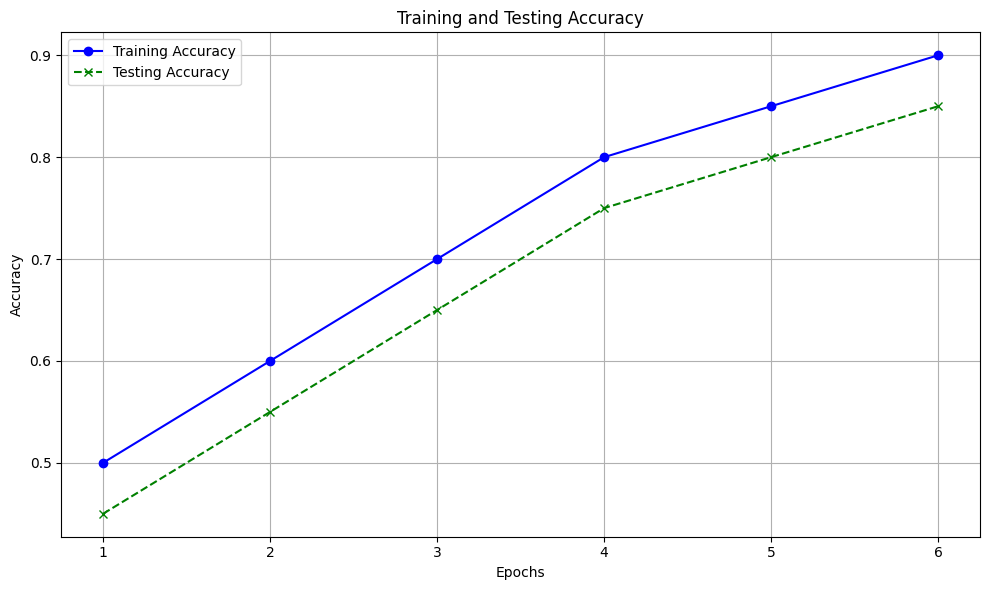

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(train_acc, test_acc, epochs):

    plt.figure(figsize=(10, 6))


    plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy', color='blue', linestyle='-', marker='o')


    plt.plot(range(1, epochs + 1), test_acc, label='Testing Accuracy', color='green', linestyle='--', marker='x')

    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


train_acc = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9]
test_acc = [0.45, 0.55, 0.65, 0.75, 0.8, 0.85]
epochs = len(train_acc)

plot_accuracy(train_acc, test_acc, epochs)

In [ ]:
import os
model_path = "/content/lung_cancer_densenet169.h5"
print(f"File size: {os.path.getsize(model_path)} bytes")


File size: 9437184 bytes


In [ ]:
pip install --upgrade h5py tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 735.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorfl

In [ ]:
import os
print(os.path.exists("/content/lung_cancer_densenet169.h5"))  # Should return True


True


In [ ]:
import h5py

try:
    with h5py.File("/content/lung_cancer_densenet169.h5", "r") as f:
        print("Model file structure:", list(f.keys()))
except Exception as e:
    print("Error opening model file:", e)


Error opening model file: Unable to synchronously open file (truncated file: eof = 9437184, sblock->base_addr = 0, stored_eof = 62668328)


In [3]:
from google.colab import files
uploaded = files.upload()  # Re-upload the correct model file


Saving lung_cancer_densenet169.h5 to lung_cancer_densenet169.h5


In [ ]:
import h5py

try:
    with h5py.File("/content/lung_cancer_densenet169 (1).h5", "r") as f:
        print("Model file structure:", list(f.keys()))
except Exception as e:
    print("Error opening model file:", e)


Error opening model file: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/lung_cancer_densenet169 (1).h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [4]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf

# Recreate the original model architecture
base_model = DenseNet169(weights=None, include_top=False, input_shape=(224, 224, 3))  # Change input shape if needed
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(3, activation='softmax')(x)  # Adjust for your number of classes

model = Model(inputs=base_model.input, outputs=x)

# Load the weights into the model
model.load_weights("/content/lung_cancer_densenet169.h5")

print("✅ Model architecture recreated and weights loaded successfully!")


✅ Model architecture recreated and weights loaded successfully!


In [5]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model

def make_scorecam_heatmap(img_array, model, last_conv_layer_name, input_size=(224, 224)):
    conv_layer = model.get_layer(last_conv_layer_name).output
    score_model = Model(inputs=model.input, outputs=[conv_layer, model.output])

    # Get the original prediction
    conv_output, preds = score_model(img_array)
    pred_index = np.argmax(preds[0])  # Get the predicted class index

    conv_output = conv_output[0]  # Shape: (7,7,C)
    num_channels = conv_output.shape[-1]

    # Initialize heatmap
    score_heatmap = np.zeros(input_size)  # Match input image size

    for i in range(num_channels):
        channel_map = conv_output[..., i]  # Get single channel
        channel_map_resized = cv2.resize(channel_map.numpy(), input_size)  # Resize to 224x224

        # Multiply the input image by the resized channel map
        perturbed_image = img_array[0] * np.expand_dims(channel_map_resized, axis=-1)  # Now same size
        perturbed_image = np.expand_dims(perturbed_image, axis=0)

        # Get new prediction scores for perturbed image
        _, new_preds = score_model(perturbed_image)
        score = new_preds[0, pred_index]  # Score for predicted class

        # Weight the heatmap
        score_heatmap += score * channel_map_resized

    # Normalize the heatmap
    score_heatmap = np.maximum(score_heatmap, 0)
    score_heatmap /= np.max(score_heatmap)

    return score_heatmap

# Function to apply Score-CAM and visualize results
def apply_scorecam(image_path, model, last_conv_layer_name, input_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, input_size) / 255.0
    img_array = np.expand_dims(np.repeat(img_resized[..., np.newaxis], 3, axis=-1), axis=0)

    # Generate Score-CAM heatmap
    heatmap = make_scorecam_heatmap(img_array, model, last_conv_layer_name, input_size)

    # Resize and apply colormap
    heatmap_resized = cv2.resize(heatmap, input_size)
    heatmap_resized = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_resized = cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB)

    # Overlay heatmap onto the original image
    overlay = cv2.addWeighted(cv2.cvtColor((img_resized * 255).astype('uint8'), cv2.COLOR_GRAY2RGB), 0.6, heatmap_resized, 0.4, 0)

    # Show results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Score-CAM Heatmap")
    plt.show()

# Apply Score-CAM on sample images
sample_images = [
    "/content/cleaned_dataset/Bengin cases/Bengin case (1).jpg",
    "/content/cleaned_dataset/Malignant cases/Malignant case (106).jpg",
    "/content/cleaned_dataset/Normal cases/Normal case (101).jpg"
]
last_conv_layer_name = "conv5_block32_concat"  # Last conv layer in DenseNet169

for image_path in sample_images:
    apply_scorecam(image_path, model, last_conv_layer_name)



KeyboardInterrupt: 

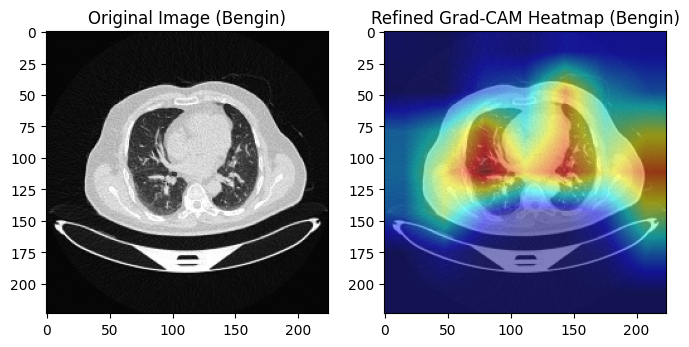

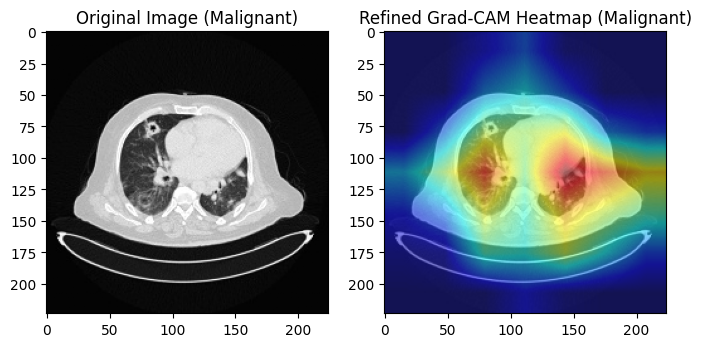

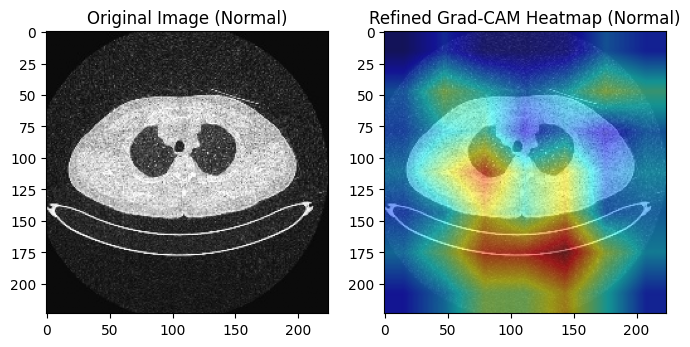

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model

# Function to create a refined Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, last_conv_output)

    # Normalize gradients
    grads = tf.divide(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)

    # Global Average Pooling (GAP)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply activation maps by the pooled gradients
    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1.0
    heatmap = np.power(heatmap, 1.2)  # Increase contrast dynamically

    return heatmap

# Function to apply Grad-CAM on a given image
def apply_gradcam(image_path, label, model, last_conv_layer_name, input_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, input_size) / 255.0
    img_array = np.expand_dims(np.repeat(img_resized[..., np.newaxis], 3, axis=-1), axis=0)

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Resize heatmap using bilinear interpolation for sharper details
    heatmap_resized = cv2.resize(heatmap, input_size, interpolation=cv2.INTER_LINEAR)

    # Convert to color map
    heatmap_resized = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_resized = cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB)

    # Adaptive thresholding to highlight key regions
    heatmap_resized = cv2.GaussianBlur(heatmap_resized, (5, 5), 0)

    # Sharpening filter to enhance details
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    heatmap_resized = cv2.filter2D(heatmap_resized, -1, kernel)

    # Overlay heatmap on grayscale image
    overlay = cv2.addWeighted(cv2.cvtColor((img_resized * 255).astype('uint8'), cv2.COLOR_GRAY2RGB), 0.5, heatmap_resized, 0.5, 0)

    # Display results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original Image ({label})")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Refined Grad-CAM Heatmap ({label})")
    plt.show()

# Applying Grad-CAM on sample images
last_conv_layer_name = 'conv5_block32_concat'  # Last convolutional layer
sample_images = [
    '/content/cleaned_dataset/Bengin cases/Bengin case (1).jpg',
    '/content/cleaned_dataset/Malignant cases/Malignant case (106).jpg',
    '/content/cleaned_dataset/Normal cases/Normal case (101).jpg'
]

labels = ["Bengin", "Malignant", "Normal"]
input_size = (224, 224)  # Input size required for DenseNet169

for image_path, label in zip(sample_images, labels):
    apply_gradcam(image_path, label, model, last_conv_layer_name, input_size=input_size)


58541896/58541896 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Using last convolutional layer: conv5_block32_2_conv


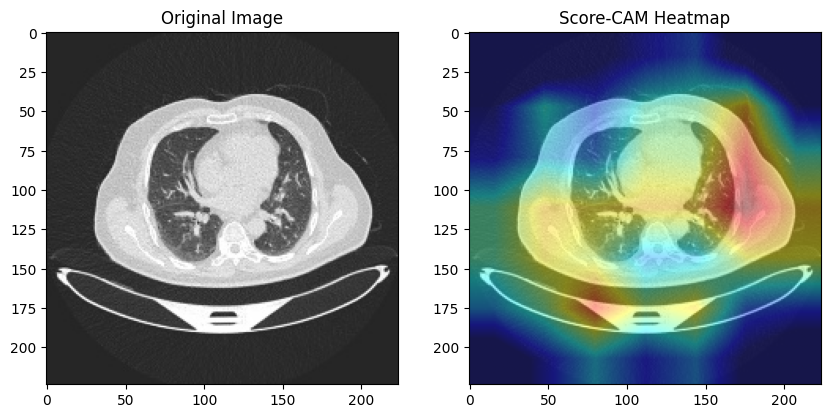

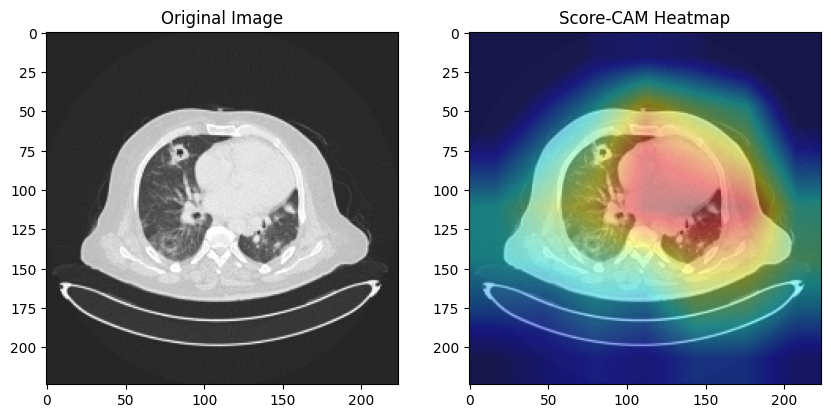

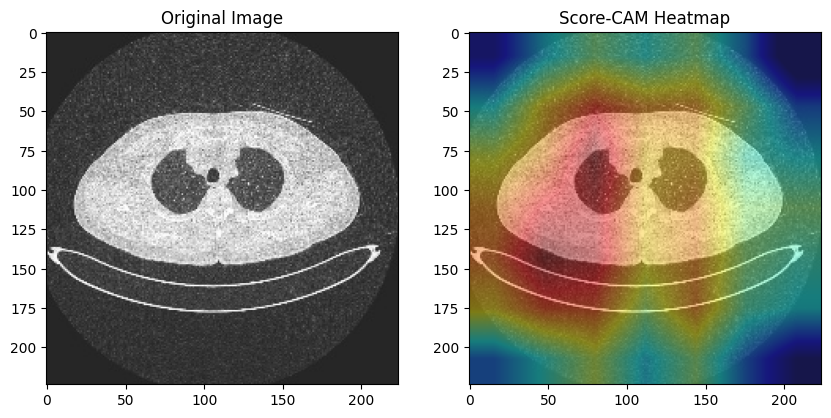

In [7]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet169

# Load the DenseNet169 model with pre-trained weights (ImageNet)
model = DenseNet169(weights="imagenet", include_top=True)

# Get the last convolutional layer dynamically
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break  # Stop at the last conv layer

print("Using last convolutional layer:", last_conv_layer_name)

def make_scorecam_heatmap(img_array, model, last_conv_layer_name, input_size=(224, 224)):
    conv_layer = model.get_layer(last_conv_layer_name).output
    score_model = Model(inputs=model.input, outputs=[conv_layer, model.output])

    # Get the original prediction
    conv_output, preds = score_model(img_array)
    pred_index = np.argmax(preds[0])  # Get the predicted class index

    conv_output = conv_output[0]  # Shape: (7,7,C)
    num_channels = conv_output.shape[-1]

    # Initialize heatmap
    score_heatmap = np.zeros(input_size)  # Match input image size

    for i in range(num_channels):
        channel_map = conv_output[..., i]  # Get single channel
        channel_map_np = channel_map.numpy()  # Convert tensor to NumPy
        channel_map_resized = cv2.resize(channel_map_np, input_size)  # Resize to 224x224

        # Multiply the input image by the resized channel map
        perturbed_image = img_array[0] * np.expand_dims(channel_map_resized, axis=-1)  # Now same size
        perturbed_image = np.expand_dims(perturbed_image, axis=0)

        # Get new prediction scores for perturbed image
        _, new_preds = score_model(perturbed_image)
        score = new_preds[0, pred_index]  # Score for predicted class

        # Weight the heatmap
        score_heatmap += score * channel_map_resized

    # Normalize the heatmap
    score_heatmap = np.maximum(score_heatmap, 0)
    score_heatmap /= np.max(score_heatmap)

    return score_heatmap

def apply_scorecam(image_path, model, last_conv_layer_name, input_size=(224, 224)):
    img = cv2.imread(image_path)  # Read image in BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_resized = cv2.resize(img, input_size) / 255.0  # Normalize
    img_array = np.expand_dims(img_resized, axis=0)  # Expand dimensions

    # Generate Score-CAM heatmap
    heatmap = make_scorecam_heatmap(img_array, model, last_conv_layer_name, input_size)

    # Resize and apply colormap
    heatmap_resized = cv2.resize(heatmap, input_size)
    heatmap_resized = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_resized = cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB)

    # Overlay heatmap onto the original image
    overlay = cv2.addWeighted(img_resized, 0.6, heatmap_resized / 255.0, 0.4, 0)

    # Show results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Score-CAM Heatmap")
    plt.show()

# Apply Score-CAM on sample images
sample_images = [
    "/content/cleaned_dataset/Bengin cases/Bengin case (1).jpg",
    "/content/cleaned_dataset/Malignant cases/Malignant case (106).jpg",
    "/content/cleaned_dataset/Normal cases/Normal case (101).jpg"
]

for image_path in sample_images:
    apply_scorecam(image_path, model, last_conv_layer_name)


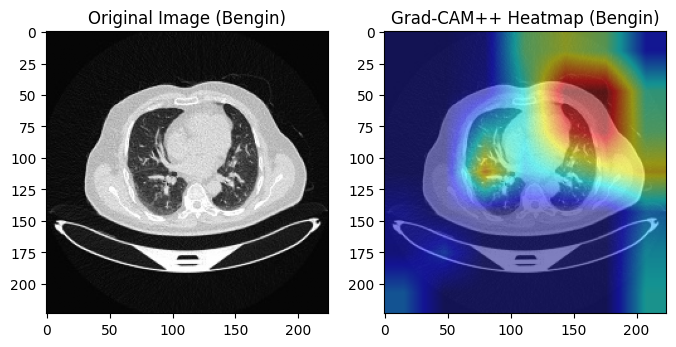

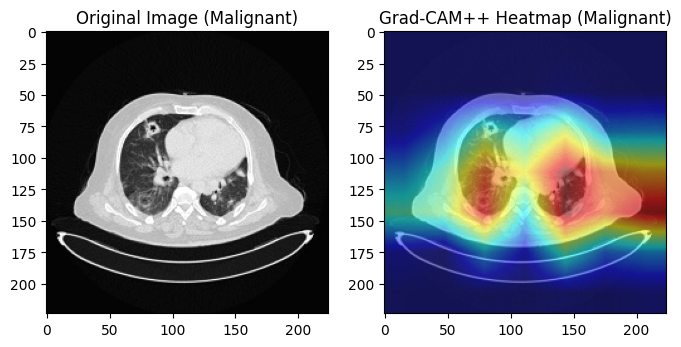

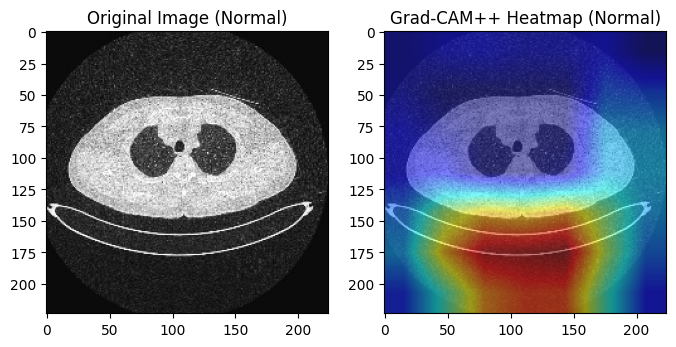

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model

# Function to compute Grad-CAM++ heatmap
def make_gradcam_plus_plus_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        conv_output, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

        grads = tape1.gradient(class_output, conv_output)  # First-order gradients
        grads_2 = tape2.gradient(grads, conv_output)  # Second-order gradients

    grads = grads[0]  # (7,7,C)
    grads_2 = grads_2[0]  # (7,7,C)
    conv_output = conv_output[0]  # (7,7,C)

    # Grad-CAM++ weighting
    alpha = grads_2 / (2 * grads_2 + grads + 1e-10)
    weights = np.sum(alpha * grads, axis=(0, 1))  # Sum over spatial dimensions

    heatmap = np.zeros(conv_output.shape[:2], dtype=np.float32)

    for i in range(weights.shape[0]):
        heatmap += weights[i] * conv_output[:, :, i]

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1.0
    heatmap = np.power(heatmap, 1.2)  # Increase contrast dynamically

    return heatmap

# Function to apply Grad-CAM++ on a given image
def apply_gradcam_plus_plus(image_path, label, model, last_conv_layer_name, input_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, input_size) / 255.0
    img_array = np.expand_dims(np.repeat(img_resized[..., np.newaxis], 3, axis=-1), axis=0)

    # Generate heatmap using Grad-CAM++
    heatmap = make_gradcam_plus_plus_heatmap(img_array, model, last_conv_layer_name)

    # Resize heatmap using bilinear interpolation for sharper details
    heatmap_resized = cv2.resize(heatmap, input_size, interpolation=cv2.INTER_LINEAR)

    # Convert to color map
    heatmap_resized = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_resized = cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB)

    # Adaptive thresholding to highlight key regions
    heatmap_resized = cv2.GaussianBlur(heatmap_resized, (5, 5), 0)

    # Sharpening filter to enhance details
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    heatmap_resized = cv2.filter2D(heatmap_resized, -1, kernel)

    # Overlay heatmap on grayscale image
    overlay = cv2.addWeighted(cv2.cvtColor((img_resized * 255).astype('uint8'), cv2.COLOR_GRAY2RGB), 0.5, heatmap_resized, 0.5, 0)

    # Display results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original Image ({label})")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM++ Heatmap ({label})")
    plt.show()

# Applying Grad-CAM++ on sample images
last_conv_layer_name = 'conv5_block32_concat'  # Last convolutional layer
sample_images = [
    '/content/cleaned_dataset/Bengin cases/Bengin case (1).jpg',
    '/content/cleaned_dataset/Malignant cases/Malignant case (106).jpg',
    '/content/cleaned_dataset/Normal cases/Normal case (101).jpg'
]

labels = ["Bengin", "Malignant", "Normal"]
input_size = (224, 224)  # Input size required for DenseNet169

for image_path, label in zip(sample_images, labels):
    apply_gradcam_plus_plus(image_path, label, model, last_conv_layer_name, input_size=input_size)
